In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sys import version_info
import pickle
import mlflow
import cloudpickle

from sklearn.preprocessing import PowerTransformer,QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import umap

from kmodes.kprototypes import KPrototypes

pd.options.display.float_format = '{:,.4f}'.format

In [2]:
song_df = pd.read_csv('SpotifyFeatures.csv')
song_df = song_df[(song_df['genre'] != """Children's Music""")]
song_df

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.6110,0.3890,99373,0.9100,0.0000,C#,0.3460,-1.8280,Major,0.0525,166.9690,4/4,0.8140
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.2460,0.5900,137373,0.7370,0.0000,F#,0.1510,-5.5590,Minor,0.0868,174.0030,4/4,0.8160
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.9520,0.6630,170267,0.1310,0.0000,C,0.1030,-13.8790,Minor,0.0362,99.4880,5/4,0.3680
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.7030,0.2400,152427,0.3260,0.0000,C#,0.0985,-12.1780,Major,0.0395,171.7580,4/4,0.2270
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.9500,0.3310,82625,0.2250,0.1230,F,0.2020,-21.1500,Major,0.0456,140.5760,4/4,0.3900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232720,Soul,Slave,Son Of Slide,2XGLdVl7lGeq8ksM6Al7jT,39,0.0038,0.6870,326240,0.7140,0.5440,D,0.0845,-10.6260,Major,0.0316,115.5420,4/4,0.9620
232721,Soul,Jr Thomas & The Volcanos,Burning Fire,1qWZdkBl4UVPj9lK6HuuFM,38,0.0329,0.7850,282447,0.6830,0.0009,E,0.2370,-6.9440,Minor,0.0337,113.8300,4/4,0.9690
232722,Soul,Muddy Waters,(I'm Your) Hoochie Coochie Man,2ziWXUmQLrXTiYjCg2fZ2t,47,0.9010,0.5170,166960,0.4190,0.0000,D,0.0945,-8.2820,Major,0.1480,84.1350,4/4,0.8130
232723,Soul,R.LUM.R,With My Words,6EFsue2YbIG4Qkq8Zr9Rir,44,0.2620,0.7450,222442,0.7040,0.0000,A,0.3330,-7.1370,Major,0.1460,100.0310,4/4,0.4890


In [3]:
song_df.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,"227,322.0000","227,322.0000","227,322.0000","227,322.0000","227,322.0000","227,322.0000","227,322.0000","227,322.0000","227,322.0000","227,322.0000","227,322.0000"
mean,42.0039,0.3633,0.5510,"237,318.4014",0.5751,0.1484,0.2162,-9.5206,0.1208,117.5842,0.4497
std,17.4395,0.3540,0.1849,"118,897.1779",0.2633,0.3027,0.1993,6.0240,0.1860,30.9051,0.2582
min,0.0000,0.0000,0.0569,"15,509.0000",0.0000,0.0000,0.0097,-52.4570,0.0222,30.3790,0.0000
25%,30.0000,0.0356,0.4320,"185,078.5000",0.3930,0.0000,0.0976,-11.6470,0.0367,92.7510,0.2340
50%,44.0000,0.2230,0.5670,"221,736.0000",0.6120,0.0000,0.1290,-7.6800,0.0500,115.6000,0.4380
75%,55.0000,0.7140,0.6880,"267,000.0000",0.7900,0.0365,0.2660,-5.4640,0.1050,139.1105,0.6530
max,100.0000,0.9960,0.9870,"5,552,917.0000",0.9990,0.9990,1.0000,3.7440,0.9670,242.9030,1.0000


In [4]:
song_df.describe(include=['O'])

,genre,artist_name,track_name,track_id,key,mode,time_signature
count,227322,227322,227322,227322,227322,227322,227322
unique,26,14400,144676,171372,12,2,5
top,Comedy,Giuseppe Verdi,Home,3uSSjnDMmoyERaAK9KvpJR,C,Major,4/4
freq,9681,1394,100,8,26604,147036,196298


In [5]:
song_info = song_df.iloc[:,0:4].copy().drop_duplicates()
song_attributes = song_df.iloc[:,3:].copy().drop_duplicates()

In [6]:
song_unique = song_attributes.copy().reset_index(drop=True)
song_unique['rank'] = song_unique.groupby('track_id')['popularity'].rank(ascending=False)
song_unique = song_unique[(song_unique['rank']==1)].drop(['rank'],axis=1)
song_track = song_unique.iloc[:,0]
song_features = song_unique.iloc[:,1:]

In [7]:
song_unique.describe(include=['O'])

,track_id,key,mode,time_signature
count,171370,171370,171370,171370
unique,171370,12,2,5
top,0BRjO6ga9RKCKjfDqeFgWV,C,Major,4/4
freq,1,19990,111912,144724


In [8]:
def float_table(df):
    for x in df.columns:
        try:
            df[x] = df[x].astype(np.float64)
        except:
            pass
    return df

In [33]:
ct = ColumnTransformer([("scale", QuantileTransformer(output_distribution='normal'), song_features.select_dtypes(exclude='object').columns),],remainder="passthrough",verbose=True,verbose_feature_names_out=False)
song_scale = float_table(pd.DataFrame(ct.fit_transform(song_features),columns=ct.get_feature_names_out()))
song_scale

[ColumnTransformer] ......... (1 of 2) Processing scale, total=   1.5s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s


,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode,time_signature
0,-5.1993,0.4124,-0.7681,-1.7203,1.2867,-5.1993,0.9185,2.4180,0.0917,1.3544,1.2475,C#,Major,4/4
1,-2.0331,-0.0464,0.1931,-1.2836,0.4640,-5.1993,0.1753,0.6839,0.5743,1.6386,1.2585,F#,Minor,4/4
2,-1.9029,1.2867,0.5895,-0.8478,-1.2896,-5.1993,-0.5394,-0.7943,-0.7250,-0.3992,-0.1855,C,Minor,5/4
3,-5.1993,0.5282,-1.3717,-1.0985,-0.7381,-5.1993,-0.6580,-0.6130,-0.4696,1.5210,-0.6364,C#,Major,4/4
4,-1.8448,1.2753,-0.9979,-1.9319,-0.9897,0.6991,0.4252,-1.4291,-0.1372,0.7529,-0.1182,F,Major,4/4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171365,0.2953,-0.9938,-1.1449,0.5298,0.4710,0.3945,0.0753,0.2077,-0.2381,1.7658,2.0331,C,Major,4/4
171366,-0.3322,0.3620,-0.6196,-1.1983,-0.7120,-5.1993,0.6580,-0.7133,-0.2278,-1.2099,0.1855,A#,Minor,4/4
171367,0.0100,-0.7497,1.3653,0.7977,0.2666,0.2332,0.5409,0.2635,-0.9575,-0.0299,2.6517,E,Minor,4/4
171368,0.5207,1.0188,-0.1817,-0.8971,-0.5106,-5.1993,-0.7647,-0.0385,0.8958,-0.9773,1.2421,D,Major,4/4


In [ ]:
song_tnse = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(song_scale.select_dtypes(exclude='object'))
pd.DataFrame(song_tnse,columns=['Dim1','Dim2']).to_csv("tnse_2.csv",index=False)

In [ ]:
song_tnse = TSNE(n_components=3, learning_rate='auto',init='random').fit_transform(song_scale.select_dtypes(exclude='object'))
pd.DataFrame(song_tnse,columns=['Dim1','Dim2','Dim3']).to_csv("tnse_3.csv",index=False)

In [38]:
song_tnse = pd.read_csv('tnse2.csv')

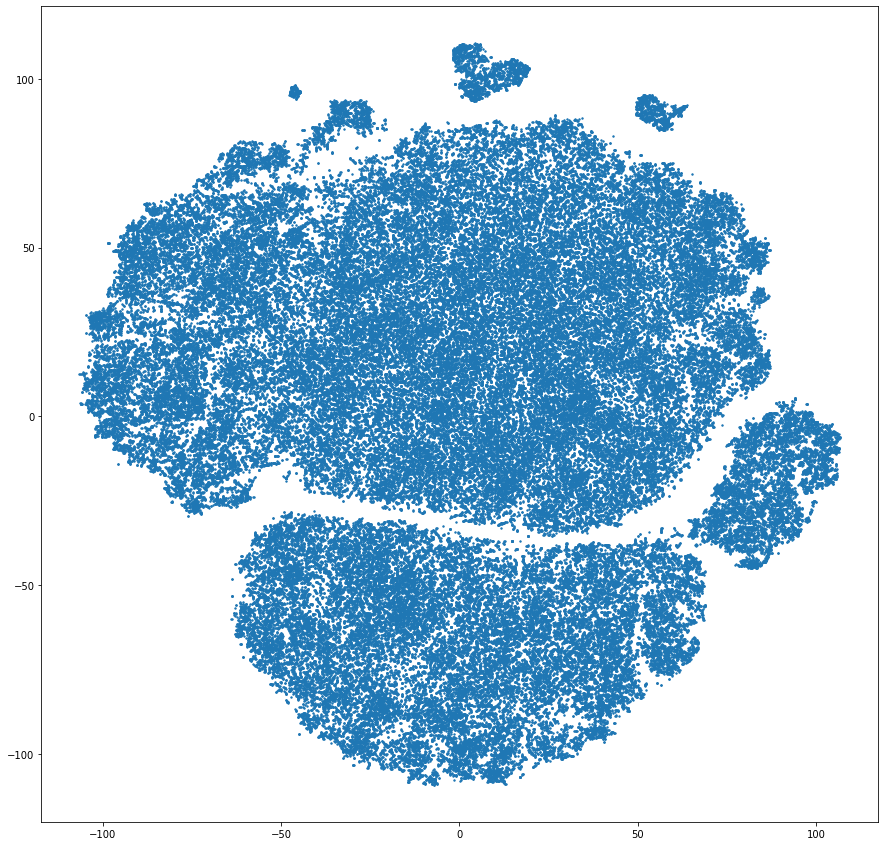

In [39]:
plt.figure(figsize=(15, 15))
plt.scatter(song_tnse.iloc[:,0],song_tnse.iloc[:,1], s=2, cmap='tab20b', alpha=1.0)
plt.show()

In [68]:
numerical = song_scale.select_dtypes(exclude='object')

categorical = pd.get_dummies(song_scale.select_dtypes(include='object'))
categorical_weight = len(song_scale.select_dtypes(include='object').columns) / song_scale.shape[1]

fit1 = umap.UMAP(metric='l2',n_components=3,min_dist=.25).fit(numerical)
fit2 = umap.UMAP(metric='hamming',n_components=3,min_dist=.25).fit(categorical)

intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)
embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False, {}, False)

/usr/local/lib/python3.9/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


In [69]:
embedding

(array([[-4.809515 ,  5.853318 , 12.184184 ],
        [ 5.868283 , -3.61173  ,  4.3788853],
        [ 4.3123565, -2.3530447,  5.3068414],
        ...,
        [ 6.3919044, 10.679728 ,  5.2648168],
        [ 5.8538446, -3.0551639,  6.69112  ],
        [ 4.293571 ,  9.997083 ,  6.8696527]], dtype=float32),
 {})

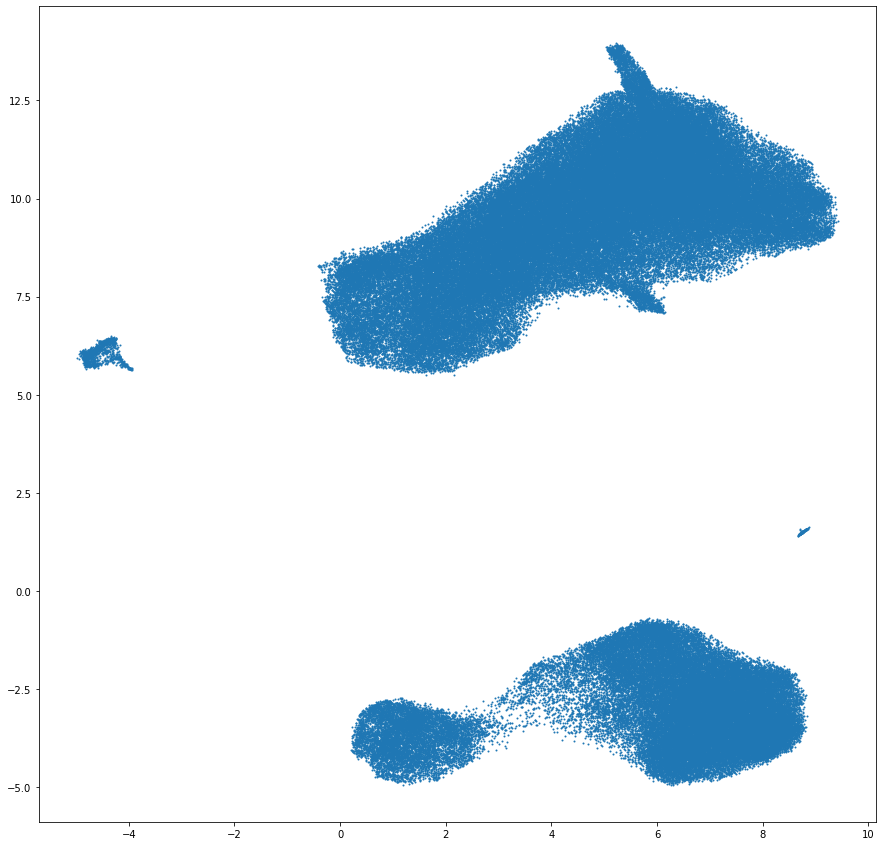

In [71]:
plt.figure(figsize=(15, 15))
plt.scatter(embedding[0][:,0],embedding[0][:,1], s=1, cmap='tab20b', alpha=1.0)
plt.show()

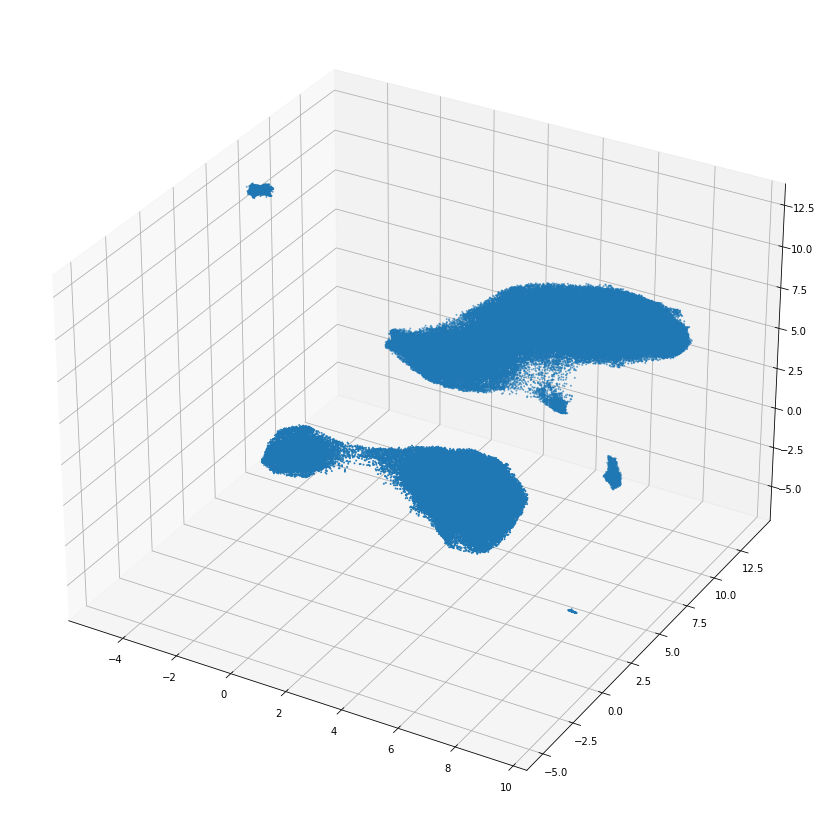

In [70]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')
ax.scatter(embedding[0][:,0], embedding[0][:,1], embedding[0][:,2], s=1, cmap='tab20b')
plt.show()

In [76]:
categorical_columns = [i for i,x in enumerate(song_scale.columns) if x in song_scale.select_dtypes(include='object').columns]

In [77]:
categorical_columns

[11, 12, 13]

In [78]:
kproto = KPrototypes(n_clusters= 15, init='Cao', n_jobs = 4)
kprotoModel = kproto.fit(song_scale, categorical=categorical_columns)
clusters = kprotoModel.predict(song_scale)

TypeError: argument of type 'NoneType' is not iterable

In [ ]:
#mlflow.set_tracking_uri("databricks")
#mlflow.set_experiment("/Users/connor.mccambridge@sprint.com/Medium/K-Prototype")

In [ ]:
inits = ['Huang','Cao','random']
ns = range(1,20)
params = [(x,y) for x in inits for y in ns]

In [ ]:
PYTHON_VERSION = "{major}.{minor}.{micro}".format(major=version_info.major,minor=version_info.minor,micro=version_info.micro)

conda_env = {
    'channels': ['defaults'],
    'dependencies': [
      'python={}'.format(PYTHON_VERSION),
      'pip',
      {
        'pip': [
          'mlflow',
          'kproto=={}'.format(kproto.__version__),
          'cloudpickle=={}'.format(cloudpickle.__version__),
        ],
      },
    ],
    'name': 'kproto_env'
}

In [ ]:
import mlflow.pyfunc
class kprotoWrapper(mlflow.pyfunc.PythonModel):

    def load_context(self, context):
        import pickle
        self.kproto_model = pickle.load(open(context.artifacts["kproto_model"], "rb" ))

    def predict(self, context, model_input):
        return self.kproto_model.predict(model_input)

In [ ]:
with mlflow.start_run():

    kproto_model_path = "model.kproto"

    pickle.dump(kprotoModel, open(kproto_model_path, "wb" ))

    artifacts = {
        "kproto_model": kproto_model_path
    }

    mlflow_pyfunc_model_path = "kproto_mlflow_pyfunc"
    mlflow.pyfunc.save_model(path=mlflow_pyfunc_model_path, python_model=kprotoWrapper(), artifacts=artifacts)

    mlfow.end_run()